# Warm up 14 - Vehicle Stock in China

TEP4290, Spring 2024

## Preparation: Packages and data imports

Start by importing the necessary packages:

In [56]:
# Write all the necessary imports here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from dynamic_stock_model import DynamicStockModel

Then import the data into a Dataframe using the pandas read_excel function (check the documentation to find out which arguments to use) and clean it.

In [57]:
#Working directory ?
working_directory = os.getcwd()
print(working_directory)

c:\Users\jujug\Documents\Ecole\4. NTNU\MFA2\TEP4290\TEP4290-juliette\Warm_up_14_chinese_vehicle_fleet


In [58]:
# Extracting data from the source file into a panda Dataframe
file = "Warm_up_14_data.xls"
# This file should be placed in the same directory as this notebook (on the JupyterHub server)

# We read the data and store it in a Dataframe called "data", using the read_excel() panda function
data = pd.read_excel(file, sheet_name="CarStockData",usecols="D:P", header =1,)

# Drop the first two rows
data = data.drop(index=[0,1])
data = data.reset_index(drop=True)

# This is just to replace all the void values in "data" by 0, which makes things easier
data.fillna(0, inplace=True)


C:\Users\jujug\AppData\Local\Temp\ipykernel_25860\3479403728.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.fillna(0, inplace=True)


We create two Dataframes from data:
 - historic_data with values up to 2008
 - future_data with values for 2009 and after


In [59]:
historic_data = data[data.Time < 2009]
future_data = data[data.Time >= 2009]

## Inflow-driven model

Calculate outflows, stock change and stock for historic data, using an inflow-driven model:

In [ ]:
# Parameters of the lifetime distribution
mean_lifetime = 15
stddev_lifetime = 5
n_years = len(historic_data["Time"])


lt_mean = np.full(n_years, mean_lifetime)
lt_std = np.full(n_years, stddev_lifetime)

# Reset the index 
historic_data = historic_data.reset_index(drop=True)


# Create a new attribute in the class dynamic stock model
inflow_driven_model = DynamicStockModel(
    t = historic_data["Time"], 
    i = historic_data["Inflow"], 
    lt = {'Type': 'Normal', 'Mean': lt_mean, 'StdDev': lt_std })

# Compute the entire model
Stock_by_cohort, ExitFlag = inflow_driven_model.compute_s_c_inflow_driven()



In [ ]:
# Add the outflow in the historic_data
inflow_driven_model.o_c = None
Outflow_by_cohort, ExitFlag = inflow_driven_model.compute_o_c_from_s_c()
outflow_total = Outflow_by_cohort.sum(axis=1)
historic_data["Outflow"] = outflow_total

# Compute the stock change in historic data
historic_data["Stock Change"] = historic_data["Inflow"] - historic_data["Outflow"]

#Compute stock in historic data
historic_data["Stock"] = historic_data["Stock Change"].cumsum()


In [ ]:
# merge historic data and data
data["Outflow"] = historic_data["Outflow"]
data["Stock Change"] = historic_data["Stock Change"]
data["Stock"] = historic_data["Stock"]

## Stock-driven model

Calculate stock change, outflows and inflows for future data, using a stock-driven model.
You need to run the stock-driven model for all years, combining historic stock data from the inflow-driven model, and future stock data from population and car ownership projections.

In [63]:
#Compute the stock between 2009 and 2050
mask = data['Time'] >= 2009
data.loc[mask, "Stock"] = data.loc[mask, "cars per 1000 people"] * data.loc[mask, "Population"]

In [64]:
# Parameters of the lifetime distribution for the entire data
n_years = len(data["Time"])
lt_mean = np.full(n_years, mean_lifetime)
lt_std = np.full(n_years, stddev_lifetime)

# Create the stock driven model
stock_driven_model = DynamicStockModel(t = data["Time"], 
                                       s = data["Stock"], 
                                       lt = {'Type': 'Normal', 'Mean': lt_mean, 'StdDev': lt_std })

CheckStr, ExitFlag = stock_driven_model.dimension_check()
print(CheckStr)


<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 101 years.<br>Inflow is not present.<br>Total stock is present with 101 years.<br>Stock by cohorts is not present.<br>Total outflow is not present.<br>Outflow by cohorts is not present.<br>Lifetime distribution is present with type Normal and mean [15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15].<br>


In [ ]:
# Compute the entire model
S_C, O_C, I, ExitFlag = stock_driven_model.compute_stock_driven_model()
O, ExitFlag   = stock_driven_model.compute_outflow_total()
DS, ExitFlag  = stock_driven_model.compute_stock_change()
Bal, ExitFlag = stock_driven_model.check_stock_balance()
print(Bal)
     

[ 0.00000000e+00  0.00000000e+00  4.54747351e-13  0.00000000e+00
  4.54747351e-13  0.00000000e+00  9.09494702e-13 -1.36424205e-12
 -9.09494702e-13  9.09494702e-13 -3.18323146e-12 -4.54747351e-13
  3.63797881e-12  1.81898940e-12  0.00000000e+00 -4.54747351e-12
  2.72848411e-12  4.54747351e-12 -6.36646291e-12  4.54747351e-12
 -2.72848411e-12  1.81898940e-12 -7.27595761e-12  1.45519152e-11
 -1.09139364e-11 -7.27595761e-12  0.00000000e+00  3.63797881e-12
  2.91038305e-11 -3.63797881e-11  1.45519152e-11 -4.36557457e-11
 -7.27595761e-12  1.23691279e-10 -4.36557457e-11  0.00000000e+00
 -8.73114914e-11  5.82076609e-11 -8.73114914e-11  5.82076609e-11
  5.82076609e-11  1.16415322e-10 -1.16415322e-10 -2.32830644e-10
  5.82076609e-10 -1.16415322e-10  0.00000000e+00  3.49245965e-10
 -3.49245965e-10 -1.16415322e-10  0.00000000e+00 -4.65661287e-10
  6.98491931e-10 -1.39698386e-09  9.31322575e-10  1.86264515e-09
 -4.65661287e-09  1.86264515e-09  1.86264515e-09 -5.58793545e-09
  6.51925802e-09 -1.86264

In [66]:
# extract the outflow 
stock_driven_model.o_c = None 
Outflow_by_cohort, ExitFlag_O = stock_driven_model.compute_o_c_from_s_c()
outflow_total = Outflow_by_cohort.sum(axis=1)

# add the outflow and inflow in future data
data["Outflow"] = outflow_total
data["Inflow"] = I

# compute stock and stock change in future data
data["Stock Change"] = data["Inflow"] - data["Outflow"]
data["Stock"] = S_C.sum(axis=1)

In [67]:
# Save the data to a new excel file
data.to_excel("Warm_up_14_new_data.xlsx", index=False)

## Final calculations

Perform the calculations for distance driven, fuel consumption and CO2 emissions

In [68]:
#Compute the Stock_TC

#create à 101*101 matrix
n_total = len(data["Time"])
n_hist = len(historic_data)
stock_tc = np.zeros((n_total, n_total))

# Add the historic data
stock_tc[:n_hist,:n_hist] = inflow_driven_model.s_c

# Add the future data
stock_tc[n_hist:, :] = S_C[n_hist:, :]

In [69]:
# car per 1000 people = data["Stock"] / data["Population"] * 1000
historic_mask = data["Time"] <= 2008
data.loc[historic_mask, "cars per 1000 people"] = (data.loc[historic_mask, "Stock"] / data.loc[historic_mask, "Population"])

# Total direct CO2 emissions (billion/km year) = data["Stock"] * data["Kilometrage per vehicle"] / 1e9
data["Total direct CO2 emissions"] = data["Stock"] * data["Kilometrage per vehicle"] / 1e9

# total fuel consumption (million liters/year) = einsum(tc,c)
data["Total gasoline consumend"] = np.einsum('tc,c->t', stock_tc, data["Fuel efficiency"].values / 100) * data["Kilometrage per vehicle"].values / 1e6

# total carbon emissions (Mt/year) = data["Total fuel consumption"] * data["Carbon Intensity"] / 1e6
data["Total direct CO2 emissions"] = (data["Total gasoline consumend"] * data["Carbon intensity"].values) / 1000
                                                     
                                                                                                        

In [70]:
# Save the data to a new excel file
data.to_excel("Warm_up_14_new_data.xlsx", index=False)

## Plot the results

Plot the results of the model for inflows and outflows, stock change, stock, total distance driven, total fuel consumption, and total CO2 emissions

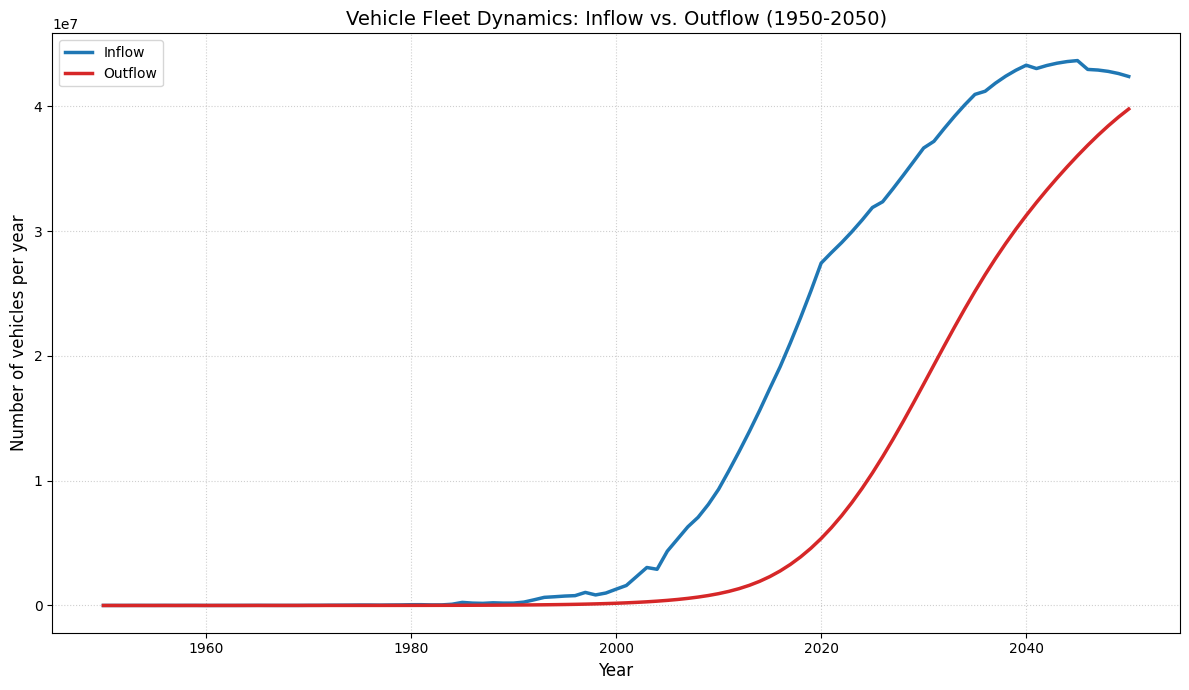

In [71]:
# Inflows and outflows
plt.figure(figsize=(12, 7))

# Plot Inflow 
plt.plot(data["Time"], data["Inflow"], 
         color="#1f77b4", linewidth=2.5, label="Inflow")

# Plot Outflow 
plt.plot(data["Time"], data["Outflow"], 
         color="#d62728", linewidth=2.5, label="Outflow")



# Formatting the plot
plt.title("Vehicle Fleet Dynamics: Inflow vs. Outflow (1950-2050)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of vehicles per year", fontsize=12)

# Add grid and legend
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc='upper left')

# Adjust layout and show
plt.tight_layout()

# save the figure
plt.savefig("Vehicle_Inflow_Outflow.png", dpi=300)
plt.show()



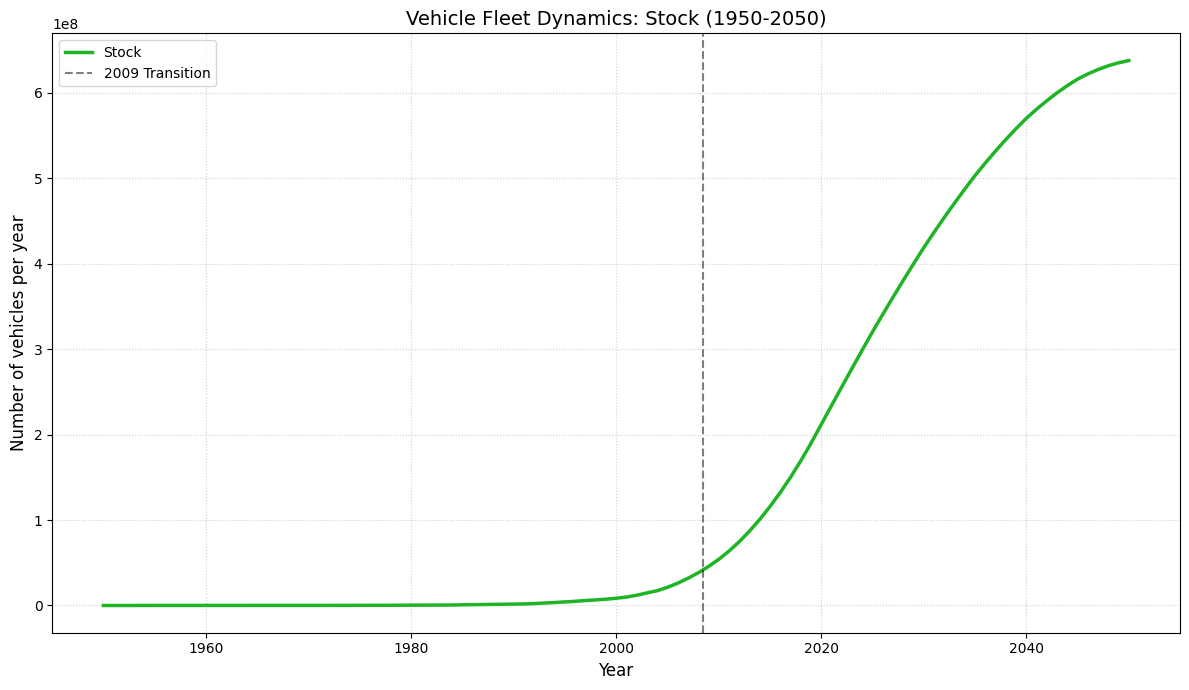

In [72]:
# Srock
plt.figure(figsize=(12, 7))

# Plot stock (Vehicles in use)
plt.plot(data["Time"], data["Stock"], 
         color="#1fb426", linewidth=2.5, label="Stock")

# Add a vertical line for the transition between Historical and Future data
plt.axvline(x=2008.5, color='black', linestyle='--', alpha=0.5, label="2009 Transition")

# Formatting the plot
plt.title("Vehicle Fleet Dynamics: Stock (1950-2050)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of vehicles per year", fontsize=12)

# Add grid and legend
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc='upper left')

# Adjust layout and show
plt.tight_layout()

# save the figure
plt.savefig("Vehicle_stock.png", dpi=300)
plt.show()



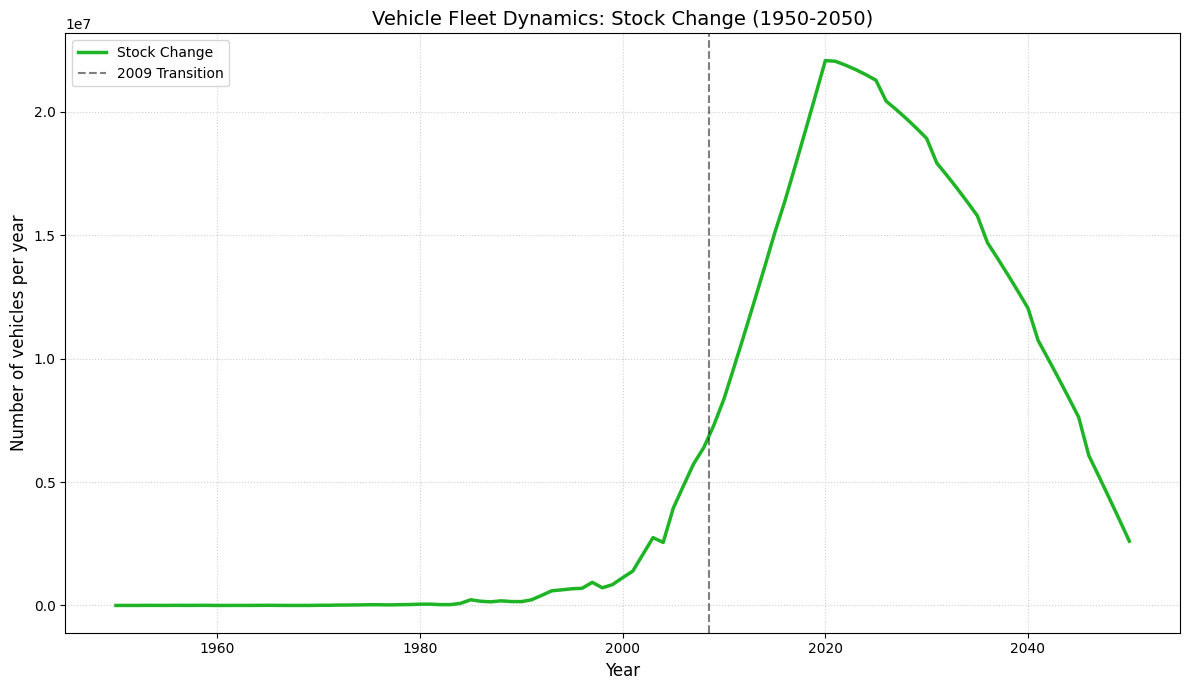

In [73]:
# Stock change
plt.figure(figsize=(12, 7))

# Plot stock (Vehicles in use)
plt.plot(data["Time"], data["Stock Change"], 
         color="#1fb426", linewidth=2.5, label="Stock Change")

# Add a vertical line for the transition between Historical and Future data
plt.axvline(x=2008.5, color='black', linestyle='--', alpha=0.5, label="2009 Transition")

# Formatting the plot
plt.title("Vehicle Fleet Dynamics: Stock Change (1950-2050)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of vehicles per year", fontsize=12)

# Add grid and legend
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc='upper left')

# Adjust layout and show
plt.tight_layout()

# save the figure
plt.savefig("Vehicle_stock_change.png", dpi=300)
plt.show()

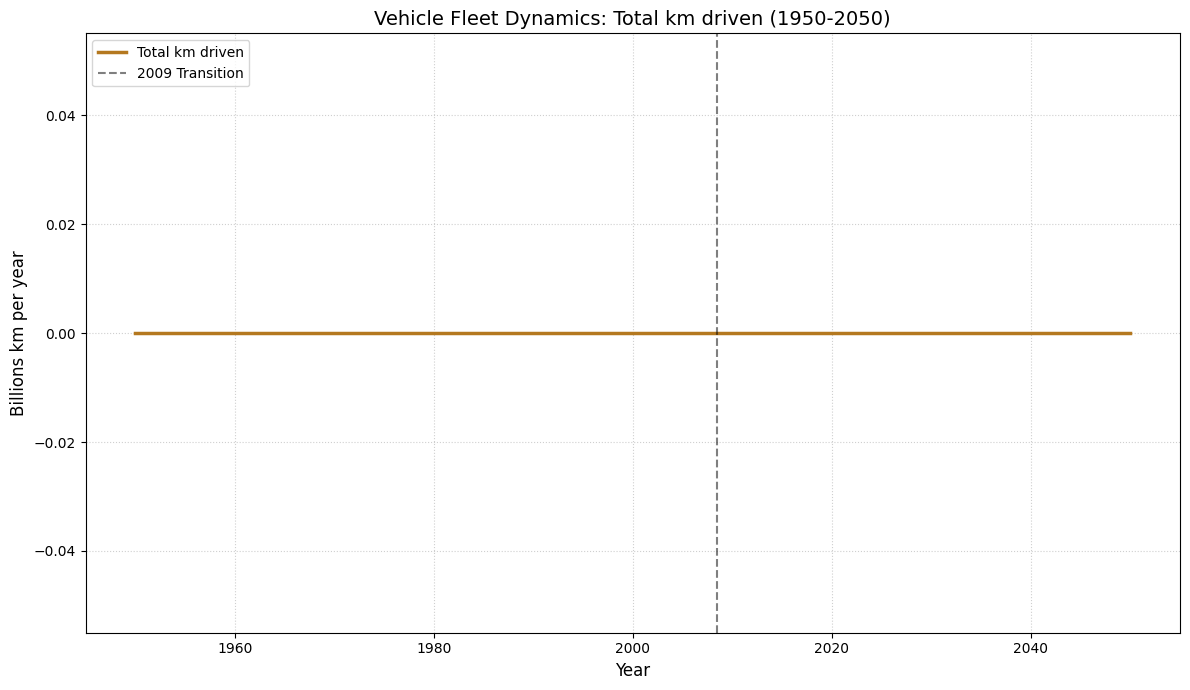

In [74]:
# Total km driven
plt.figure(figsize=(12, 7))

# Plot stock (Vehicles in use)
plt.plot(data["Time"], data["Total km driven"], 
         color="#b4781f", linewidth=2.5, label="Total km driven")

# Add a vertical line for the transition between Historical and Future data
plt.axvline(x=2008.5, color='black', linestyle='--', alpha=0.5, label="2009 Transition")

# Formatting the plot
plt.title("Vehicle Fleet Dynamics: Total km driven (1950-2050)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Billions km per year", fontsize=12)

# Add grid and legend
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc='upper left')

# Adjust layout and show
plt.tight_layout()

# save the figure
plt.savefig("Vehicle_km_driven.png", dpi=300)
plt.show()



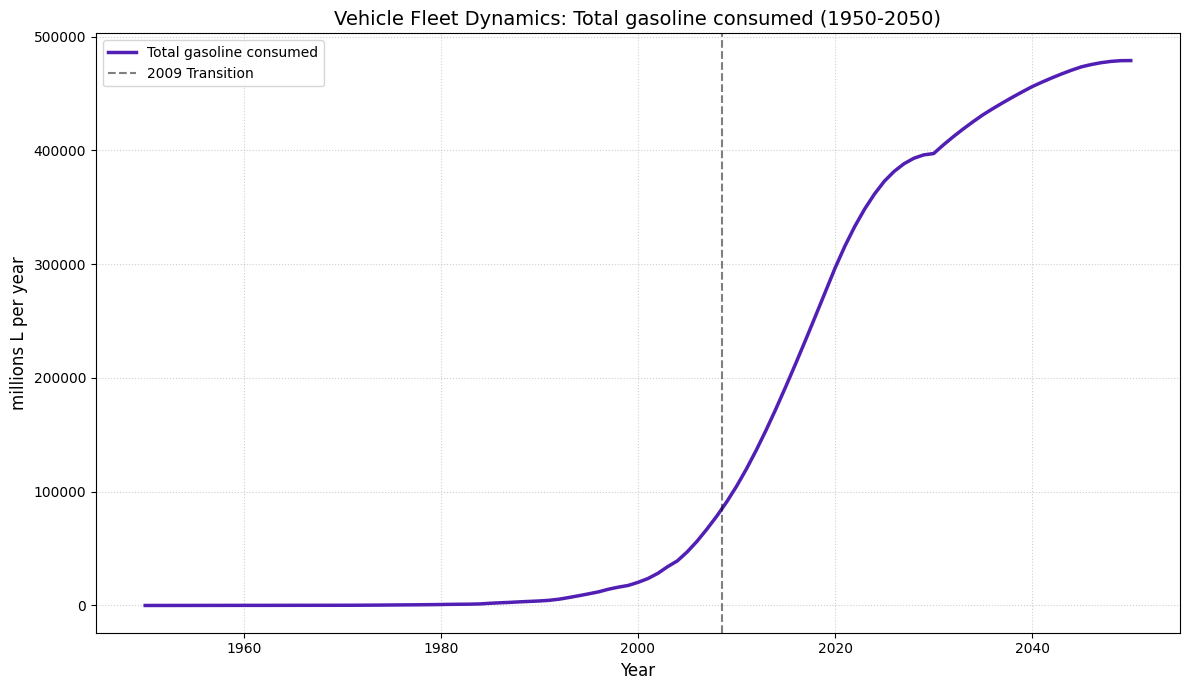

In [75]:
# Total gasoline consumed
plt.figure(figsize=(12, 7))

# Plot stock (Vehicles in use)
plt.plot(data["Time"], data["Total gasoline consumend"], 
         color="#511fb4", linewidth=2.5, label="Total gasoline consumed")

# Add a vertical line for the transition between Historical and Future data
plt.axvline(x=2008.5, color='black', linestyle='--', alpha=0.5, label="2009 Transition")

# Formatting the plot
plt.title("Vehicle Fleet Dynamics: Total gasoline consumed (1950-2050)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("millions L per year", fontsize=12)

# Add grid and legend
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc='upper left')

# Adjust layout and show
plt.tight_layout()

# save the figure
plt.savefig("Vehicle_fuel.png", dpi=300)
plt.show()



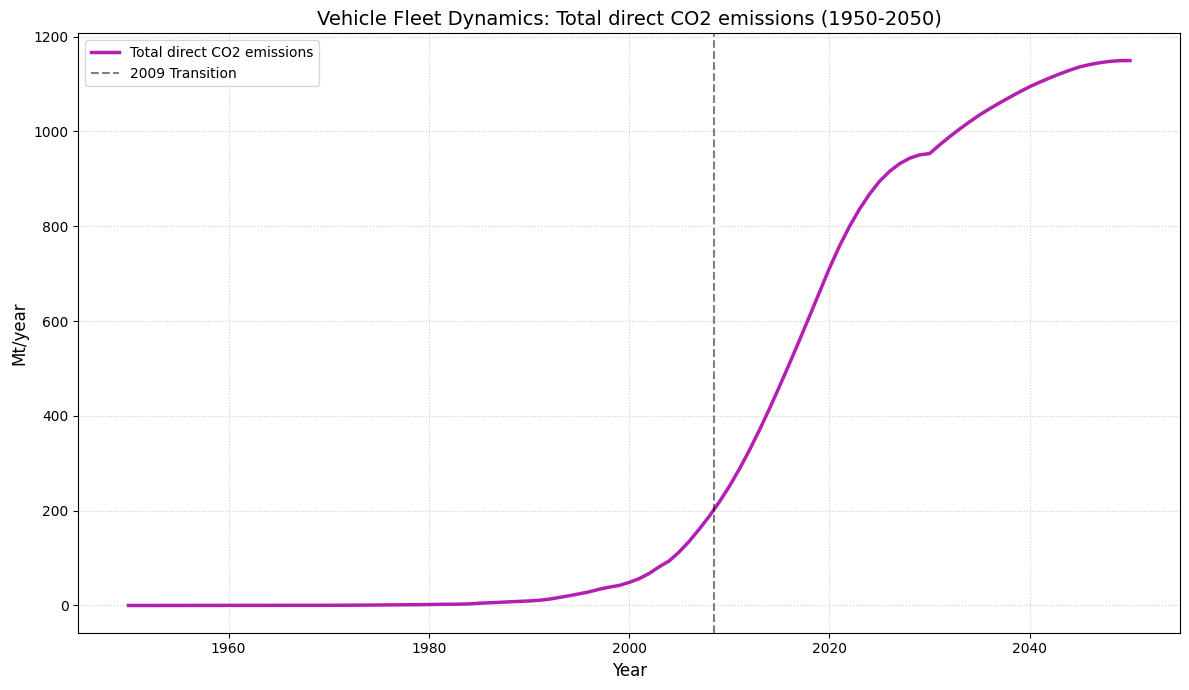

In [76]:
# Total CO2 emissions
plt.figure(figsize=(12, 7))

# Plot stock (Vehicles in use)
plt.plot(data["Time"], data["Total direct CO2 emissions"], 
         color="#b41fb2", linewidth=2.5, label="Total direct CO2 emissions")

# Add a vertical line for the transition between Historical and Future data
plt.axvline(x=2008.5, color='black', linestyle='--', alpha=0.5, label="2009 Transition")

# Formatting the plot
plt.title("Vehicle Fleet Dynamics: Total direct CO2 emissions (1950-2050)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Mt/year", fontsize=12)

# Add grid and legend
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc='upper left')

# Adjust layout and show
plt.tight_layout()

# save the figure
plt.savefig("Vehicle_co2.png", dpi=300)
plt.show()



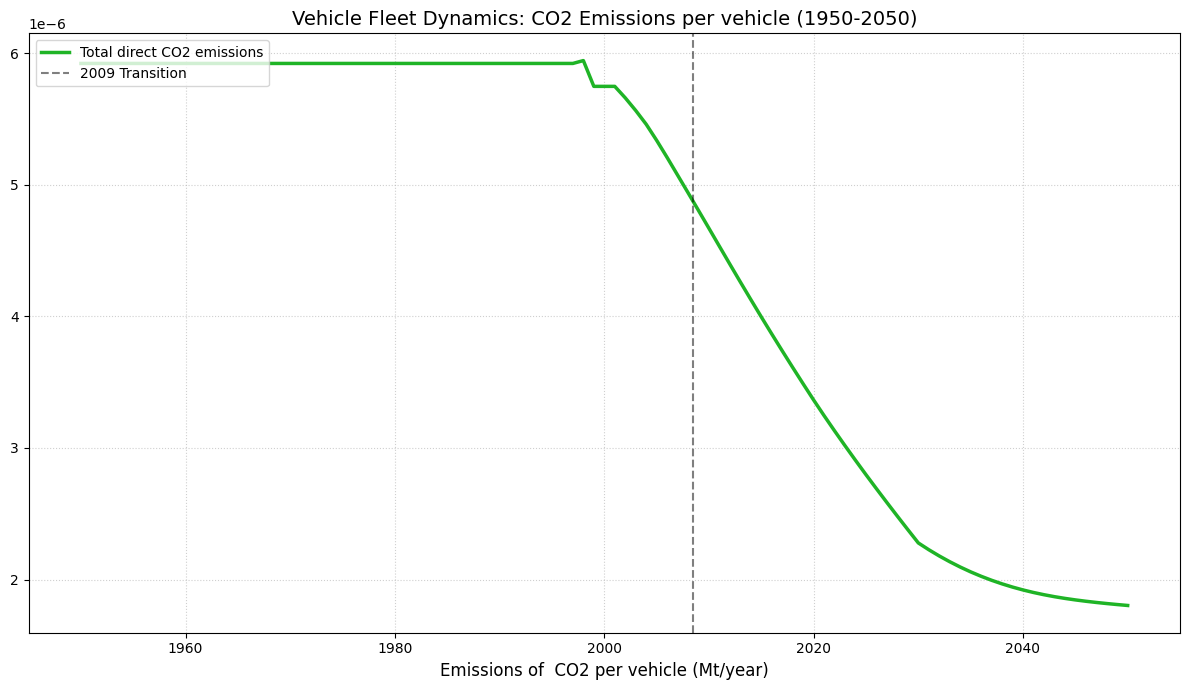

In [80]:
# Per vehicle CO2 emissions
plt.figure(figsize=(12, 7))

# Plot stock (Vehicles in use)
plt.plot(data["Time"], data["Total direct CO2 emissions"]/data["Stock"], 
         color="#1fb426", linewidth=2.5, label="Total direct CO2 emissions")

# Add a vertical line for the transition between Historical and Future data
plt.axvline(x=2008.5, color='black', linestyle='--', alpha=0.5, label="2009 Transition")

# Formatting the plot
plt.title("Vehicle Fleet Dynamics: CO2 Emissions per vehicle (1950-2050)", fontsize=14)
plt.xlabel("Emissions of  CO2 per vehicle (Mt/year)", fontsize=12)

# Add grid and legend
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc='upper left')

# Adjust layout and show
plt.tight_layout()
plt.savefig("Carbon_footprint.png", dpi=300)
plt.show()

## Exports the results

Export the results to a new Excel file - you can then in the end before submission copy the stock over to the existing data if you prefer to, but it is not required of you

In [81]:
# Save the data to a new excel file
data.to_excel("Warm_up_14_new_data.xlsx", index=False)
pd.DataFrame(stock_tc).to_excel("Warm_up_14_stock_tc.xlsx", index=False)

## Interpretation

Looking at the inflow and outflow of vehicles, we see a massive increase after the year 2000. New car sales (inflows) jumped from 1 million in 2000 to 40 million by 2040. After this peak, the growth starts to slow down.

This trend is reflected in the stock change (how fast the fleet grows). We see a 'drop' around 2020, meaning the stock is still growing but at a slower pace. About 15 years later—which is the average lifetime of a car—the total stock starts to stabilize as new cars mostly replace old ones. We expect the total fleet to reach a maximum of 650 million vehicles, a stabilization supported by the shrinking population in China.

Carbon emissions follow a similar path to the total stock, reaching a peak around 2050. Total emissions rise from 10,000 Mt/year in 2000 to 4.7 million Mt/year in 2050. While emissions depend mostly on the number of cars, we see the growth curve change slightly around 2035. This is likely due to the mileage (kilometrage) assumptions, as cars are driven less per year until 2035.

I also plotted the emissions per car. This value drops quickly, following the same trend as the decrease in mileage. By 2050, the average car emits only 0.00075 Mt/year (which is 750 kg/year). This shows that while the total number of cars is huge, each individual car is becoming much cleaner and used less frequently.